LSTM Stock Prediction Project Plots | ECE 539 | Aidan Pierre-Louis

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42) # random seed for reproducability
tf.random.set_seed(42)

# dow jones companies to test model on
dowjones_comps = [
    "AAPL", "MSFT", "AMZN", "GOOGL",  # Big Tech # "FB"
    "JNJ", "PFE", "MRK", "UNH", "ABT",      # Healthcare
    "PG", "KO", "PEP", "WMT", "HD",         # Consumer
    "GS", "JPM", "V", "AXP", "CRM",         # Financials
    "DIS", "NFLX", "CMCSA", "T", "INTC",    # Media & Telecom
    "NKE", "MCD", "SBUX", "CAT", "MMM",     # Industrials
    "BA", "HON", "UNP", "DOW",       # Industrials #"UTX"
    "IBM", "CSCO", "AAP", "TRV", "CVX",     # Other
    "XOM", "VZ", "MS", "RTX", "WBA"         # Other
]

Edit the comp_idx variable below in cell 3 to modify which company's data is to be used in the model according to the symbols for each Dow Jones company are listed above in cell 2. Ex: comp_idx = 0 ~ Apple, comp_idx = 1 ~ Microsoft, etc.

In [3]:
# Create lagged features for LSTM
def create_lagged_features(series, n_lags):
    df = pd.DataFrame(series)
    for i in range(1, n_lags + 1):
        df[f'lag_{i}'] = series.shift(i)
    #df.dropna(inplace=True)  # Drop rows with NaN values which are the result of shifting, use create_sequences()
    df.fillna(0.0, inplace=True) # replace rows with NaN values from shifting to prevent loss of indices, deprecates create_sequences() so use create_sequences_new()
    return df

# Prepare stock data with lagged features
def prepare_stock_data(stock_symbol, n_lags, start='2020-01-01', end='2023-01-01'):
    data = yf.download(stock_symbol, start=start, end=end)
    series = data['Close'].dropna()
    df = create_lagged_features(series, n_lags)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    #scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df)
    return scaled_data, scaler, series

# Prepare data, Hyperparam lag features
n_lags = 10
comp_idx = 0 # change the index here for selecting dow jones company to train data on
scaled_data, scaler, series = prepare_stock_data(dowjones_comps[comp_idx], n_lags)

[*********************100%%**********************]  1 of 1 completed


In [4]:
# Create sequences, deprecated function after altering create_lagged_features to maintain index count
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, :-1])
        y.append(data[i, -1])
    return np.array(X), np.array(y)

# new function to create sequences
def create_sequences_new(data):
    X, y = data[:, :-1], data[:, -1]
    # print(f'shape of x {len(X)}')
    return np.array(X), np.array(y)

def create_sequences_(data, sequence_length):
    X, y = [], []
    for i in range(len(data)):
        X.append(data[i-sequence_length:i, :-1])
        y.append(data[i, -1])
    return np.array(X), np.array(y)

sequence_length = n_lags
# X, y = create_sequences(scaled_data, sequence_length)
X, y = create_sequences_new(scaled_data)

In [5]:
# Split into training and testing sets
#split_percent = 0.9
#split = int(split_percent * len(X))

#X_train, y_train = X[:split], y[:split]
#X_test, y_test = X[split:], y[split:]

# 70/15/15 split
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))
test_size = len(X) - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

In [6]:
# Reshape data for LSTM
#X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2])) # deprecated with create_sequences
#X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2])) # deprecated with create_sequences
#X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]))
#X_val = X_val.reshape((X_val.shape[0], X_val.shape[1]))
#X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]))

X_train = np.expand_dims(X_train, axis=-1)  # Add a new axis for features
X_val = np.expand_dims(X_val, axis=-1)  # Add a new axis for features
X_test = np.expand_dims(X_test, axis=-1)  # Add a new axis for features

# TODO redundancy, create method to do all this reshaping
first_values = X_train[:, 0]
X_train[:, :, 0] = first_values

first_values = X_val[:, 0]
X_val[:, :, 0] = first_values

first_values = X_test[:, 0]
X_test[:, :, 0] = first_values

In [7]:
#X_test.shape, X_test[:10, :, :]

In [8]:
# Hyperparam, dropout prob
p = 0.2
hidden_units = 50

# Build the LSTM model
model = Sequential([
    LSTM(hidden_units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(p),
    LSTM(hidden_units, return_sequences=False),
    Dropout(p),
    Dense(25),
    Dense(1)
])

C:\Users\p_pie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
# Hyperparameters
learning_rate = 0.001
batch_size = 16
epochs = 100

optimizer = Adam(learning_rate=learning_rate)
# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])
# Train the model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), verbose=1)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0012 - loss: 0.0809 - val_accuracy: 0.0000e+00 - val_loss: 0.0157
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0012 - loss: 0.0172 - val_accuracy: 0.0000e+00 - val_loss: 0.0133
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0012 - loss: 0.0192 - val_accuracy: 0.0000e+00 - val_loss: 0.0154
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0012 - loss: 0.0184 - val_accuracy: 0.0000e+00 - val_loss: 0.0177
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0012 - loss: 0.0186 - val_accuracy: 0.0000e+00 - val_loss: 0.0152
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0012 - loss: 0.0190 - val_accuracy: 0.0000e+00 - val_loss: 0.0149
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0012 - loss: 0.0184 - val_accuracy: 0.0000e+00 - val_loss: 0.0142
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0012 - loss: 0.01

In [10]:
# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.concatenate((np.zeros((predictions.shape[0], n_lags)), predictions), axis=1))[:, -1]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


In [11]:
# Forecast next forecast_length days using the days from the test set, Hyperparam forecast length
forecast_length = 30
input_seq = X_test[-1]

# function deprecated with create_sequences
def forecast_predictions(forecast_length=30, input_seq=[]):
    predictions = []
    for _ in range(forecast_length):
        print(f'Forecast step {_+1}:')
        pred = model.predict(input_seq.reshape(1, sequence_length, X_test.shape[2]))
        new_row = np.append(input_seq[1:, -1], pred)  # Append the new prediction
        input_seq = np.vstack((input_seq[1:], new_row))  # Update the input sequence with the new prediction
        pred_inverse_scaled = scaler.inverse_transform(np.concatenate((np.zeros((1, n_lags)), pred), axis=1))[:, -1]
        predictions.append(pred_inverse_scaled[0])
    return predictions



# forecasted_values = forecast_predictions(forecast_length, input_seq)

def forecast_predictions_new(model, data, sequence_length, forecast_length, scaler):
    predictions = []
    last_sequence = data[-n_lags:]  # Take the last n_lags closing prices as the initial input
    for _ in range(forecast_length):
        print(f'Forecast step {_+1}:')
        # Reshape last_sequence to match the model input shape (1, sequence_length, 1)
        last_sequence = last_sequence.reshape((1, sequence_length, 1))
        # Predict the next value
        next_value = model.predict(last_sequence)[0, 0]
        # Append the prediction
        predictions.append(next_value)
        # Update the sequence, rolling it forward
        next_value = np.array([[next_value]])  # Reshape next_value to be 3D: (1, 1, 1)
        last_sequence = np.append(last_sequence[:, 1:, :], next_value.reshape(1, 1, 1), axis=1)
    # Inverse scale the predictions after the loop
    predictions = np.array(predictions).reshape(-1, 1)
    future_predictions = scaler.inverse_transform(np.concatenate((np.zeros((len(predictions), sequence_length)), predictions), axis=1))[:, -1]
    return future_predictions

# Use the model to forecast the next n_future days
forecasted_values = forecast_predictions_new(model, input_seq, sequence_length, forecast_length, scaler)

Forecast step 1:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Forecast step 2:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Forecast step 3:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Forecast step 4:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Forecast step 5:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Forecast step 6:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Forecast step 7:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Forecast step 8:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Forecast step 9:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Forecast step 10:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Forecast step 11:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Forecast step 12:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Forecast step 13:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Forecast step 14:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Forecast step 15:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Forecast step 16:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Forecast step 17:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Forecast step 18:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Fore

C:\Users\p_pie\AppData\Local\Temp\ipykernel_10136\610895317.py:21: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  test['Predictions'].iloc[:len(predictions)] = predictions


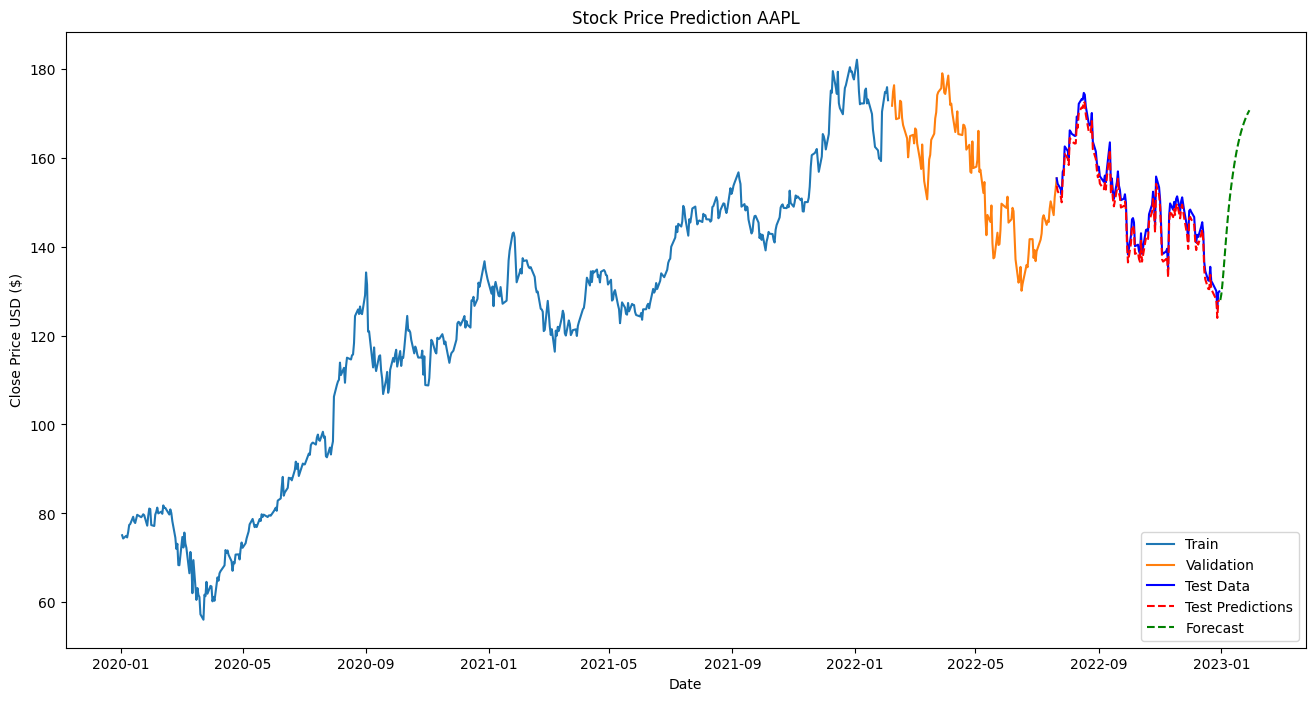

In [12]:
# Split the series into training, validation, and test parts
train = series[:train_size]
val = series[train_size:train_size+val_size]
test = series[train_size+val_size:]

# if slicing logic is wrong due to integer math
if len(val) != len(test):
    train = series[:train_size-1]
    val = series[train_size:train_size+val_size+1]
    test = series[train_size+val_size:]

# Convert to DataFrame
train = train.to_frame()
val = val.to_frame()
test = test.to_frame()

# Ensure `valid` is renamed to `val`
# Generate predictions for validation and forecast as needed
# Add predictions to the validation set
test['Predictions'] = np.nan
test['Predictions'].iloc[:len(predictions)] = predictions

# Create forecast dates (adjust if needed)
forecast_dates = pd.date_range(start=test.index[-1], periods=forecast_length + 1, inclusive='right')

# Create a DataFrame for forecasted values
forecast = pd.DataFrame(forecasted_values, index=forecast_dates, columns=['Predictions'])

# Plot the results
plt.figure(figsize=(16, 8))
plt.title(f'Stock Price Prediction {dowjones_comps[comp_idx]}')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train, label='Train')
plt.plot(val, label='Validation')
plt.plot(test['Close'], label='Test Data', linestyle='-', color='b')
plt.plot(test['Predictions'], label='Test Predictions', linestyle='--', color='r')
plt.plot(forecast, label='Forecast', linestyle='--', color='g')
plt.legend(loc='lower right')
plt.show()

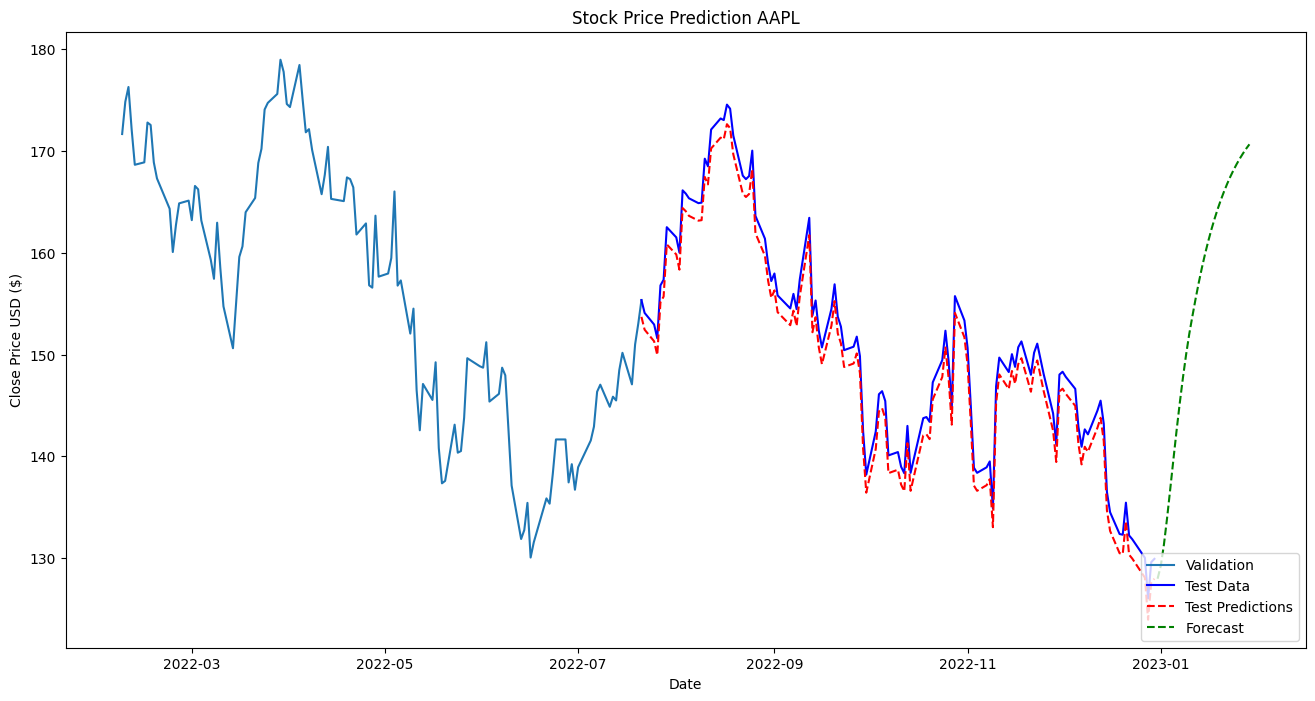

In [13]:
# Plot the results
plt.figure(figsize=(16, 8))
plt.title(f'Stock Price Prediction {dowjones_comps[comp_idx]}')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(val, label='Validation')
plt.plot(test['Close'], label='Test Data', linestyle='-', color='b')
plt.plot(test['Predictions'], label='Test Predictions', linestyle='--', color='r')
plt.plot(forecast, label='Forecast', linestyle='--', color='g')
plt.legend(loc='lower right')
plt.show()

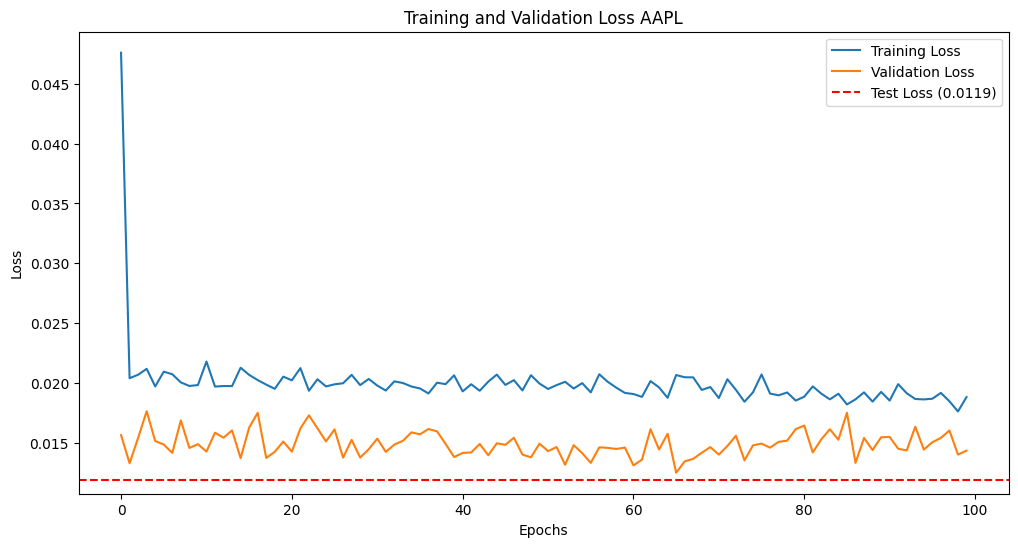

In [14]:
# Extract loss and accuracy
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history.get('accuracy', [])  # If your model records accuracy
val_accuracy = history.history.get('val_accuracy', [])

# Compute test loss
results = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
test_loss = results[0]

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label=f'Test Loss ({test_loss:.4f})')
plt.title(f'Training and Validation Loss {dowjones_comps[comp_idx]}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

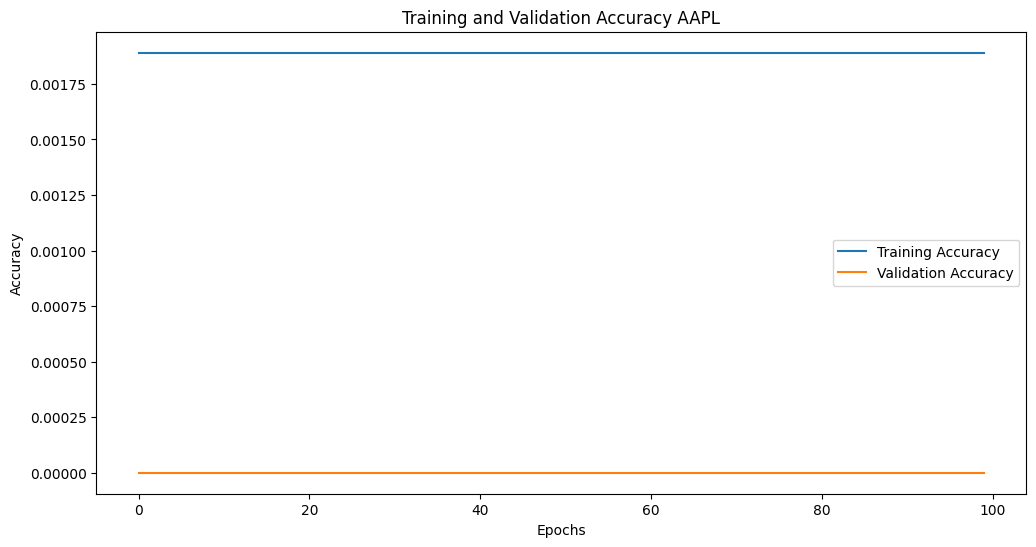

In [15]:
# Plot Training and Validation Accuracy (if applicable)
if accuracy and val_accuracy:
    plt.figure(figsize=(12, 6))
    plt.plot(accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy {dowjones_comps[comp_idx]}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()